In [1]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from transformers import AutoModel
import numpy as np
import cv2
import torch

c:\Users\Sai\Documents\Neu\video-annotation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the model and tokenizer
model = AutoModel.from_pretrained("OpenGVLab/ViCLIP-L-14-hf", trust_remote_code=True)
tokenizer = model.tokenizer
model_tokenizer = {"viclip": model, "tokenizer": tokenizer}
print("Model loaded")

# Video data
def _frame_from_video(video):
    while video.isOpened():
        success, frame = video.read()
        if success:
            yield frame
        else:
            break

# Helper functions
v_mean = np.array([0.485, 0.456, 0.406]).reshape(1, 1, 3)
v_std = np.array([0.229, 0.224, 0.225]).reshape(1, 1, 3)

def normalize(data):
    return (data / 255.0 - v_mean) / v_std

def frames2tensor(frame, target_size=(224, 224), device=torch.device('cuda')):
    frame = cv2.resize(frame[:, :, ::-1], target_size)
    frame = normalize(frame)
    frame = np.transpose(frame, (2, 0, 1))  # Change to (C, H, W) format
    frame_tensor = torch.from_numpy(frame).to(device, non_blocking=True).float().unsqueeze(0).unsqueeze(0)
    return frame_tensor

def get_text_feat_dict(texts, clip, tokenizer):
    text_feat_d = {}
    for t in texts:
        feat = clip.get_text_features(t, tokenizer)
        text_feat_d[t] = feat
    return text_feat_d

def get_vid_feat(frame_tensor, clip):
    return clip.get_vid_features(frame_tensor)

def retrieve_text_for_frame(frame, texts, models, topk=2, device=torch.device('cuda')):
    clip, tokenizer = models['viclip'], models['tokenizer']
    clip = clip.to(device)
    frame_tensor = frames2tensor(frame, device=device)
    vid_feat = get_vid_feat(frame_tensor, clip)

    text_feat_d = get_text_feat_dict(texts, clip, tokenizer)
    text_feats = [text_feat_d[t] for t in texts]
    text_feats_tensor = torch.cat(text_feats, 0)

    probs, idxs = clip.get_predict_label(vid_feat, text_feats_tensor, top=topk)
    ret_texts = [texts[i] for i in idxs.cpu().numpy()[0].tolist()]
    return ret_texts, probs.cpu().numpy()[0]

c:\Users\Sai\Documents\Neu\video-annotation\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\Sai\Documents\Neu\video-annotation\.venv\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


Model loaded


In [3]:
video = cv2.VideoCapture('test.mp4')
frames = [x for x in _frame_from_video(video)]

In [4]:
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.7)

# Detect hands and get bounding boxes
def get_hand_bboxes(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    bboxes = []

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Get min/max x and y coordinates of the landmarks
            x_coords = [landmark.x * image.shape[1] for landmark in hand_landmarks.landmark]
            y_coords = [landmark.y * image.shape[0] for landmark in hand_landmarks.landmark]
            xmin, xmax = int(min(x_coords)), int(max(x_coords))
            ymin, ymax = int(min(y_coords)), int(max(y_coords))
            bboxes.append((xmin, ymin, xmax, ymax))
    
    return bboxes

full_images = []
single_images_pairs = []
buffer = 100  # Define buffer size around the bounding box

for id, image in enumerate(frames):
    # Get bounding boxes around hands with buffer
    bboxes = get_hand_bboxes(image)

    # Crop the image for each hand
    cropped_images = [image[ymin:ymax, xmin:xmax] for xmin, ymin, xmax, ymax in bboxes]
    print(f"Frame {id} - Detected {len(cropped_images)} hands")

    if len(cropped_images) != 2:
        continue

    # Crop both the hands together with buffer
    # Get the overall min and max coordinates to include both hands in a single crop
    xmin = max(min([box[0] for box in bboxes]) - buffer, 0)
    ymin = max(min([box[1] for box in bboxes]) - buffer, 0)
    xmax = min(max([box[2] for box in bboxes]) + buffer, image.shape[1])
    ymax = min(max([box[3] for box in bboxes]) + buffer, image.shape[0])

    # Crop the image to include both hands
    cropped_image_full = image[ymin:ymax, xmin:xmax]

    full_images.append(cropped_image_full)
    single_images_pairs.append(cropped_images)

Frame 0 - Detected 2 hands
Frame 1 - Detected 2 hands
Frame 2 - Detected 0 hands
Frame 3 - Detected 1 hands
Frame 4 - Detected 1 hands
Frame 5 - Detected 1 hands
Frame 6 - Detected 1 hands
Frame 7 - Detected 1 hands
Frame 8 - Detected 0 hands
Frame 9 - Detected 0 hands
Frame 10 - Detected 0 hands
Frame 11 - Detected 1 hands
Frame 12 - Detected 1 hands
Frame 13 - Detected 0 hands
Frame 14 - Detected 1 hands
Frame 15 - Detected 1 hands
Frame 16 - Detected 1 hands
Frame 17 - Detected 1 hands
Frame 18 - Detected 1 hands
Frame 19 - Detected 1 hands
Frame 20 - Detected 1 hands
Frame 21 - Detected 2 hands
Frame 22 - Detected 2 hands
Frame 23 - Detected 2 hands
Frame 24 - Detected 2 hands
Frame 25 - Detected 2 hands
Frame 26 - Detected 2 hands
Frame 27 - Detected 2 hands
Frame 28 - Detected 2 hands
Frame 29 - Detected 2 hands
Frame 30 - Detected 2 hands
Frame 31 - Detected 2 hands
Frame 32 - Detected 2 hands
Frame 33 - Detected 2 hands
Frame 34 - Detected 2 hands
Frame 35 - Detected 2 hands
Fr

In [4]:
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

import numpy as np

def calculate_angle(a, b, c):
    """Calculate the angle between three points."""
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

def is_hand_open(hand_landmarks, image_shape):
    """Determine if the hand is open based on landmark angles."""
    # Convert normalized landmarks to pixel coordinates
    landmarks = [(int(lm.x * image_shape[1]), int(lm.y * image_shape[0])) for lm in hand_landmarks.landmark]

    # Define key landmarks for each finger
    fingers = {
        'thumb': [1, 2, 3, 4],
        'index': [5, 6, 7, 8],
        'middle': [9, 10, 11, 12],
        'ring': [13, 14, 15, 16],
        'pinky': [17, 18, 19, 20]
    }

    open_fingers = 0

    for finger, ids in fingers.items():
        # Calculate angles at the base of each finger
        angle = calculate_angle(landmarks[ids[0]], landmarks[ids[1]], landmarks[ids[2]])
        if angle > 120:  # Threshold angle to consider the finger as open
            open_fingers += 1

    # If three or more fingers are open, consider the hand as open
    # print(f"Open fingers: {open_fingers}")
    return open_fingers >= 3

In [5]:
hand_states = [] # 0 - open, 1 - closed
num_open_hands_in_sequence = []
num_closed_hands_in_sequence = []
for image in frames:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process the image to detect hands
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        open_count = 0
        close_count = 0
        for hand_landmarks in results.multi_hand_landmarks:
            # Draw hand landmarks on the image
            # mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Determine if the hand is open
            if is_hand_open(hand_landmarks, image.shape):
                # print("Hand is open")
                open_count += 1
            else:
                # print("Hand is closed")
                close_count += 1
                # pass
        
        # If both hands are open, consider the hand state as open
        if open_count == 2:
            hand_states.append(0)
        elif close_count == 2:
            hand_states.append(2)
        else:
            hand_states.append(1)

        num_open_hands_in_sequence.append(open_count)
        num_closed_hands_in_sequence.append(close_count)

        # Display the image
        # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # plt.axis('off')
        # plt.show()

C:\Users\Sai\AppData\Local\Temp\ipykernel_23660\1335080291.py:16: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)


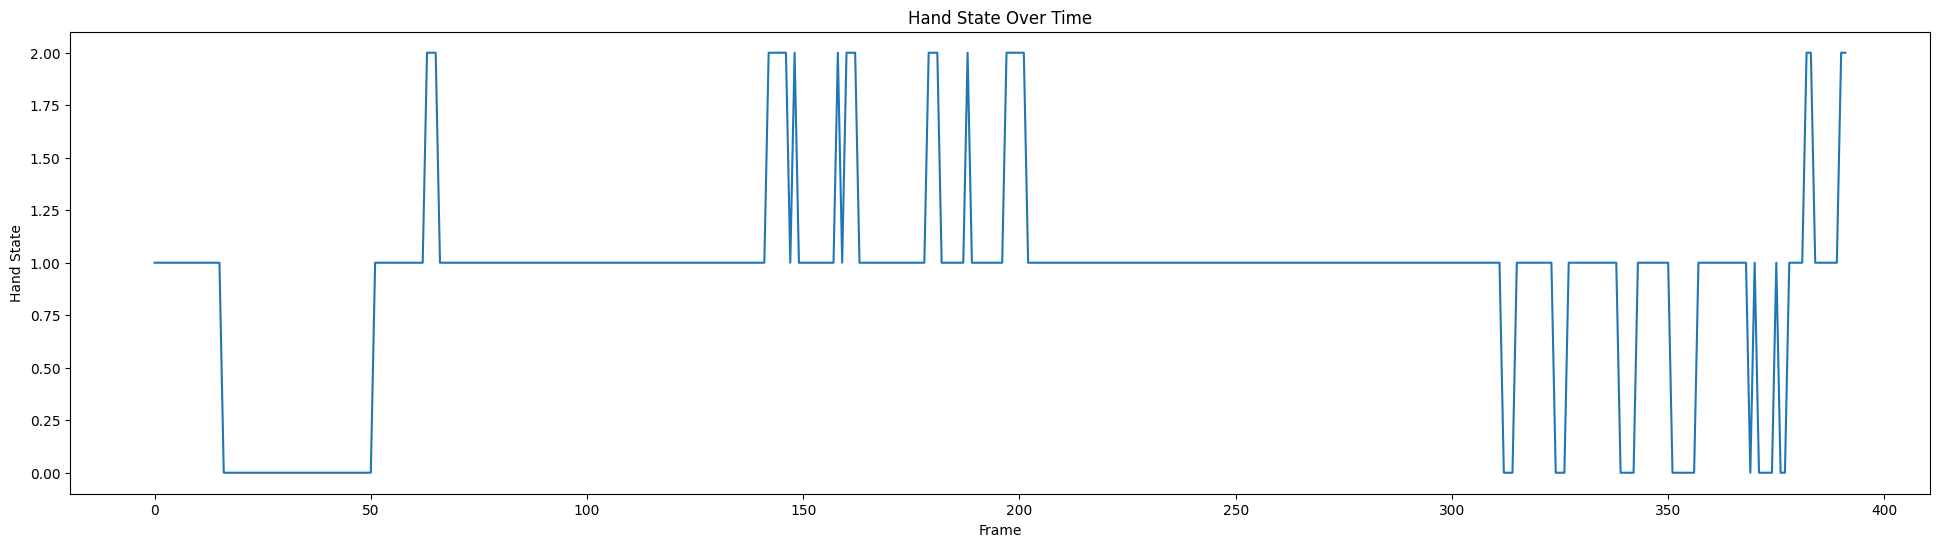

In [8]:
# Plot the hand states
plt.figure(figsize=(24, 6))
plt.plot(hand_states)
plt.xlabel('Frame')
plt.ylabel('Hand State')
plt.title('Hand State Over Time')
plt.show()

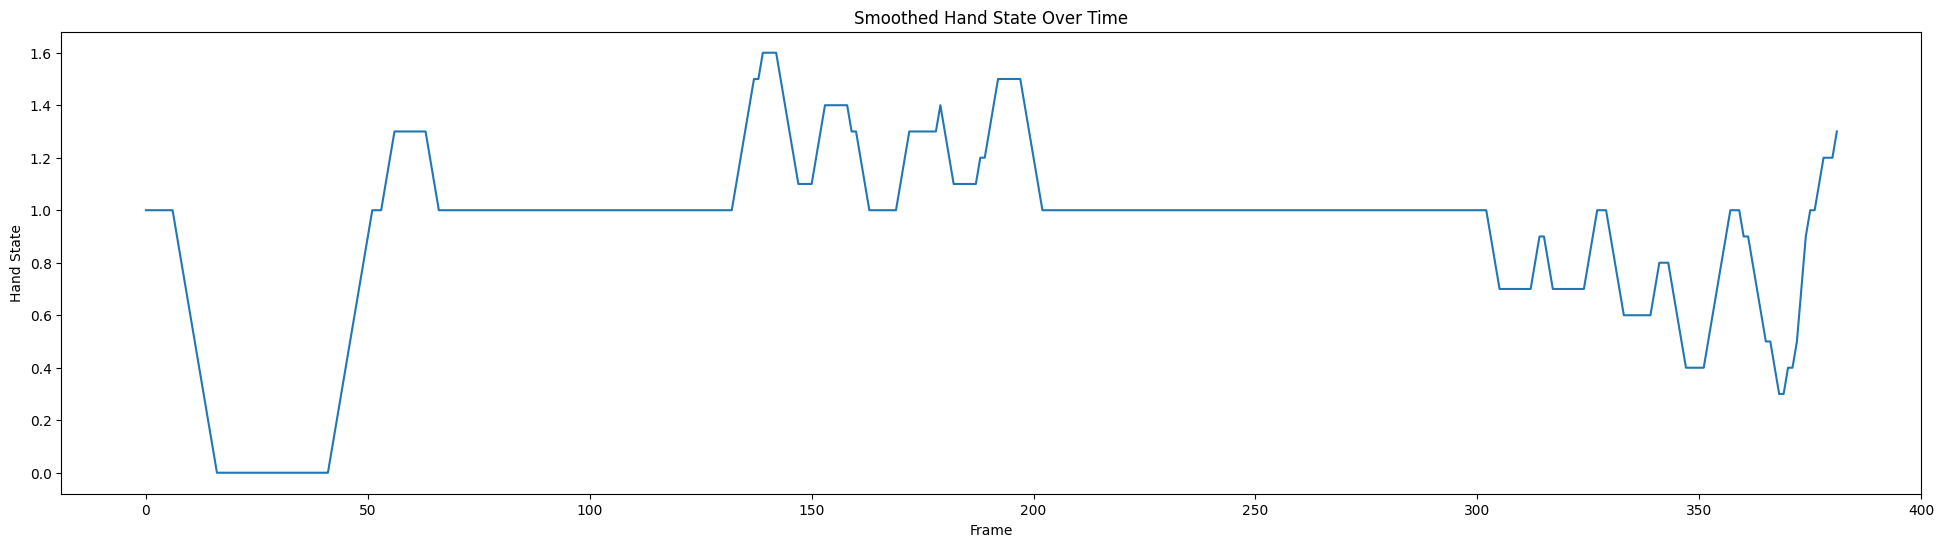

In [33]:
# Smooth the hand states using a moving average
window_size = 10
smoothed_hand_states = [sum(hand_states[i:i+window_size]) / window_size for i in range(len(hand_states) - window_size)]

# Plot the smoothed hand states
plt.figure(figsize=(24, 6))
plt.plot(smoothed_hand_states)
plt.xlabel('Frame')
plt.ylabel('Hand State')
plt.title('Smoothed Hand State Over Time')
plt.show()

In [ ]:
# Smooth the hand states using mode
from scipy.stats import mode
# Smooth the hand states using mode with a specified window size
window_size = 10
smoothed_hand_states_mode = []
for i in range(len(hand_states) - window_size + 1):
    current_window = hand_states[i:i + window_size]
    current_mode = mode(current_window)
    
    if isinstance(current_mode.mode, np.ndarray):
        current_mode = current_mode.mode[0]
    else:
        current_mode = current_mode[0]
    smoothed_hand_states_mode.append(current_mode)

# Plot the smoothed hand states
plt.figure(figsize=(24, 6))
plt.plot(range(len(smoothed_hand_states_mode)), smoothed_hand_states_mode)
plt.xlabel('Frame')
plt.ylabel('Hand State')
plt.title('Smoothed Hand State Over Time')
plt.show()

In [ ]:
# Smooth the hand states using a moving average
window_size = 10
smoothed_hand_states = [sum(hand_states[i:i+window_size]) / window_size for i in range(len(hand_states) - window_size)]

# Plot the smoothed hand states
plt.figure(figsize=(24, 6))
plt.plot(smoothed_hand_states)
plt.xlabel('Frame')
plt.ylabel('Hand State')
plt.title('Smoothed Hand State Over Time')
plt.show()

In [ ]:
# Plot the number of open and closed hands in each frame
plt.figure(figsize=(24, 6))
plt.plot(num_open_hands_in_sequence, label='Open Hands')
plt.plot(num_closed_hands_in_sequence, label='Closed Hands')
plt.xlabel('Frame')
plt.ylabel('Number of Hands')
plt.title('Number of Open and Closed Hands Over Time')
plt.legend()
plt.show()

In [ ]:
# Get Last detected open hand
hand_states = np.array(hand_states)
indices = np.flatnonzero(hand_states == 0)
last_open_hand = indices[-1]

if last_open_hand is None:
    print("No open hand detected")
else:
    print(f"Last open hand detected at frame {last_open_hand}")

# Get the last detected open hand
if last_open_hand is not None:
    last_open_hand_image = frames[last_open_hand]
    plt.imshow(cv2.cvtColor(last_open_hand_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [ ]:
print(f"Detected {len(full_images)} frames with 2 hands")

# Display all the cropped images
for i, image in enumerate(full_images):
    # plt.subplot(len(full_images), 1, i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [6]:
# Define function to get text candidates probabilities for a series of frames
def get_text_candidates_probabilities(frames, text_candidates):
    texts_list = []
    probs_list = []

    # Process each frame and print predictions
    for i, frame in enumerate(frames):
        texts, probs = retrieve_text_for_frame(frame, text_candidates, models=model_tokenizer, topk=2)
        print(f"Frame {i+1}:")

        # Initialize ordered_probs with placeholders for each text candidate
        ordered_probs = [0] * len(text_candidates)

        # Re-order probs to match text_candidates
        for t, p in zip(texts, probs):
            print(f"  text: {t} ~ prob: {p:.4f}")
            if t in text_candidates:
                idx = text_candidates.index(t)
                ordered_probs[idx] = p  # Place probability in the correct position

        # Append ordered probabilities for this frame
        probs_list.append(ordered_probs)
        texts_list.append(text_candidates)  # Store the original order for consistency

        # Display the image
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

    # Convert probs_list to a NumPy array for easier indexing
    probs_array = np.array(probs_list)

    return probs_array

In [ ]:
# Text candidates
text_candidates = ["Open Hands", "Closed Hands"]

# Get text candidates probabilities for all full images
probs_array = get_text_candidates_probabilities(full_images, text_candidates)

In [ ]:
# Get index of the frame with the highest probability for the first text candidate ("Open Hands")
max_prob_idx = np.argmax(probs_array[:, 0])  # 0 index is for "Open Hands"
max_prob_frame = full_images[max_prob_idx]
max_single_prob_frames = single_images_pairs[max_prob_idx]
print(f"Frame with the highest probability for 'Open Hands': Frame {max_prob_idx + 1} with probability {probs_array[max_prob_idx, 0]:.4f}")

# Display the frame with the highest probability for "Open Hands"
plt.imshow(cv2.cvtColor(max_prob_frame, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Optionally, display individual hand crops
for idx, hand_crop in enumerate(max_single_prob_frames):
    plt.imshow(cv2.cvtColor(hand_crop, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

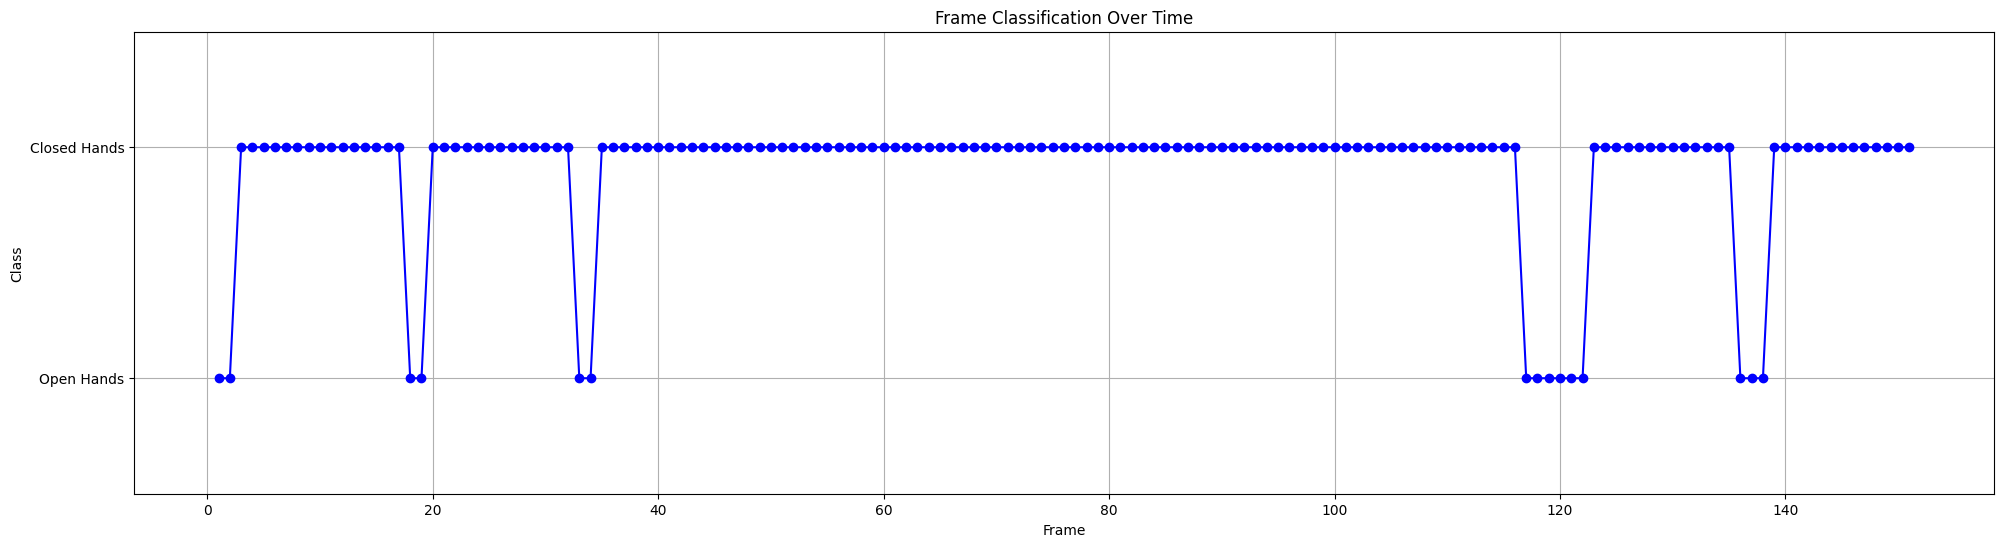

In [9]:
classifications = np.argmax(probs_array, axis=1)  # 0 for "Open Hands", 1 for "Closed Hands"

# Generate a time frame array for the x-axis
time_frames = np.arange(1, len(probs_array) + 1)

# Plot the classification over time
plt.figure(figsize=(24, 6))
plt.plot(time_frames, classifications, marker='o', linestyle='-', color='b')

# Set y-ticks to represent classes
plt.yticks([0, 1], ["Open Hands", "Closed Hands"])
plt.ylim(-0.5, 1.5)  # Slightly expand y-limits for clarity

# Add titles and labels
plt.title("Frame Classification Over Time")
plt.xlabel("Frame")
plt.ylabel("Class")

# Show the plot
plt.grid(True)
plt.show()

In [53]:
from scipy.stats import mode

def mode_filter(classifications, window_size=3):
    smoothed = []
    for i in range(len(classifications)):
        # Define the window bounds
        start = max(0, i - window_size // 2)
        end = min(len(classifications), i + window_size // 2 + 1)
        
        # Get the most common class in the window
        window_mode = mode(classifications[start:end])
        
        if isinstance(window_mode.mode, np.ndarray):
            smoothed.append(window_mode.mode[0])  # For newer versions of SciPy
        else:
            smoothed.append(window_mode[0])  # For backward compatibility
    return np.array(smoothed)

# Apply mode filtering to the classifications
window_size = 5  # Need to be adjusted based on the video frame rate
smoothed_classifications = mode_filter(classifications, window_size=window_size)

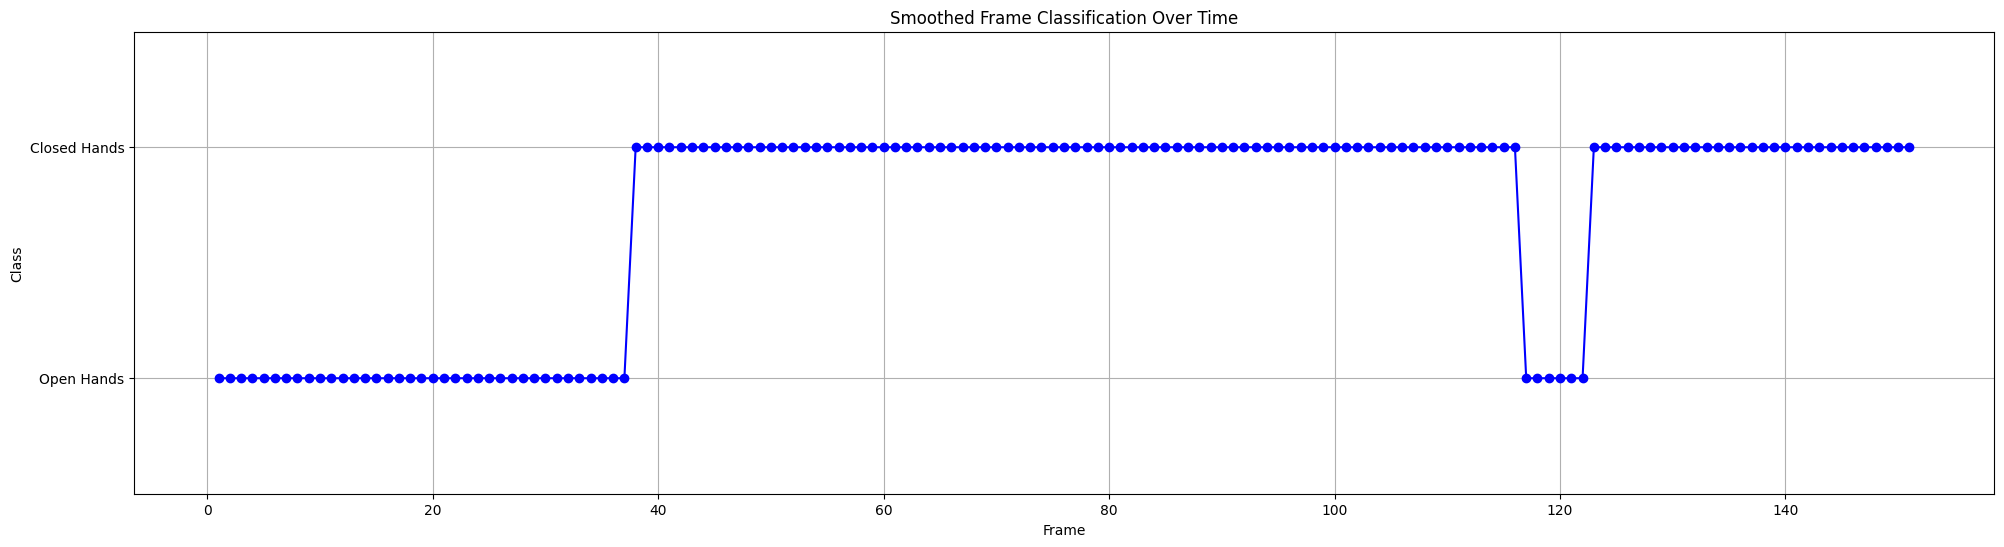

In [54]:
# Plot the smoothed classification over time
plt.figure(figsize=(24, 6))
plt.plot(time_frames, smoothed_classifications, marker='o', linestyle='-', color='b')

# Set y-ticks to represent classes
plt.yticks([0, 1], ["Open Hands", "Closed Hands"])
plt.ylim(-0.5, 1.5)  # Slightly expand y-limits for clarity

# Add titles and labels
plt.title("Smoothed Frame Classification Over Time")
plt.xlabel("Frame")
plt.ylabel("Class")

# Show the plot
plt.grid(True)
plt.show()

In [55]:
# Find all ranges of continuous "Open Hands" sequences
open_ranges = []
in_open_sequence = False
start_index = None

for i, classification in enumerate(smoothed_classifications):
    if classification == 0:  # 0 represents "Open Hands"
        if not in_open_sequence:
            # Start of a new "Open Hands" sequence
            start_index = i
            in_open_sequence = True
    else:
        if in_open_sequence:
            # End of the current "Open Hands" sequence
            open_ranges.append((start_index, i - 1))
            in_open_sequence = False

# If the last sequence was an "Open Hands" sequence, close it
if in_open_sequence:
    open_ranges.append((start_index, len(smoothed_classifications) - 1))

# Get the first and last "Open Hands" ranges, if any
first_open_range = open_ranges[0] if open_ranges else None
last_open_range = open_ranges[-1] if open_ranges else None

# Print the results
if first_open_range:
    print(f"First continuous 'Open Hands' range: Frames {first_open_range[0] + 1} to {first_open_range[1] + 1}")
else:
    print("No 'Open Hands' range found at the beginning.")

if last_open_range:
    print(f"Last continuous 'Open Hands' range: Frames {last_open_range[0] + 1} to {last_open_range[1] + 1}")
else:
    print("No 'Open Hands' range found at the end.")

First continuous 'Open Hands' range: Frames 1 to 37
Last continuous 'Open Hands' range: Frames 117 to 122


Frame 1:
  text: Empty hands ~ prob: 0.7716
  text: Non empty hands ~ prob: 0.2284


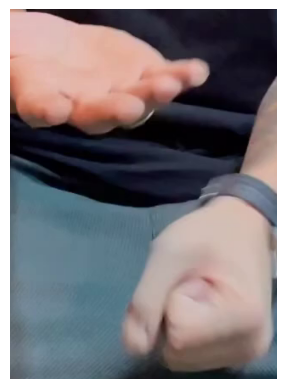

Frame 2:
  text: Empty hands ~ prob: 0.7716
  text: Non empty hands ~ prob: 0.2284


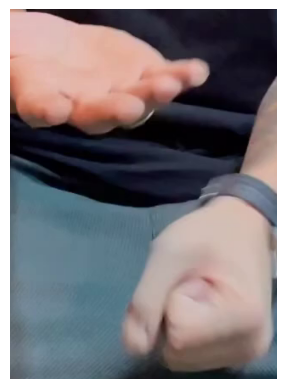

Frame 3:
  text: Non empty hands ~ prob: 0.5991
  text: Empty hands ~ prob: 0.4009


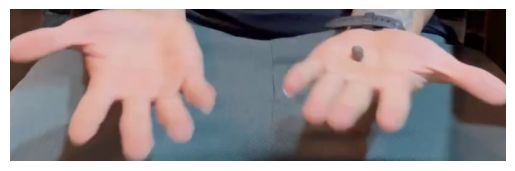

Frame 4:
  text: Non empty hands ~ prob: 0.5923
  text: Empty hands ~ prob: 0.4077


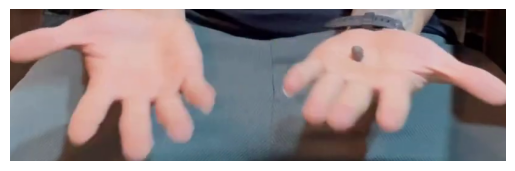

Frame 5:
  text: Non empty hands ~ prob: 0.7304
  text: Empty hands ~ prob: 0.2696


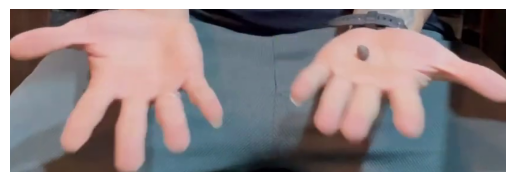

Frame 6:
  text: Non empty hands ~ prob: 0.6852
  text: Empty hands ~ prob: 0.3148


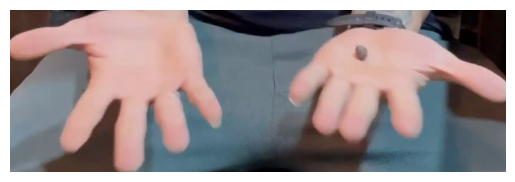

Frame 7:
  text: Non empty hands ~ prob: 0.7200
  text: Empty hands ~ prob: 0.2800


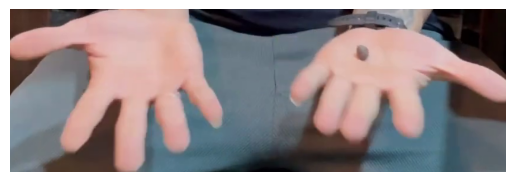

Frame 8:
  text: Non empty hands ~ prob: 0.7373
  text: Empty hands ~ prob: 0.2627


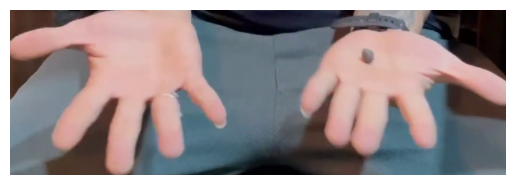

Frame 9:
  text: Non empty hands ~ prob: 0.7389
  text: Empty hands ~ prob: 0.2611


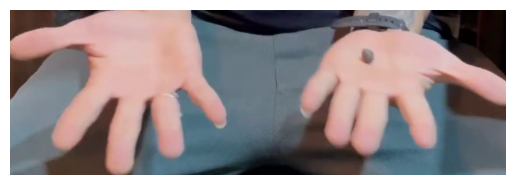

Frame 10:
  text: Non empty hands ~ prob: 0.7422
  text: Empty hands ~ prob: 0.2578


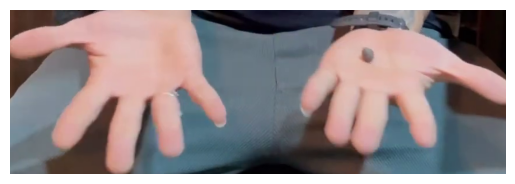

Frame 11:
  text: Non empty hands ~ prob: 0.7426
  text: Empty hands ~ prob: 0.2574


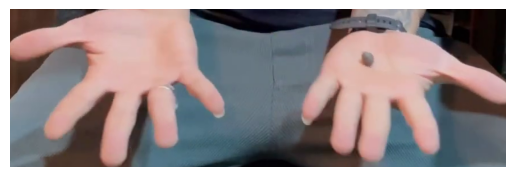

Frame 12:
  text: Non empty hands ~ prob: 0.7426
  text: Empty hands ~ prob: 0.2574


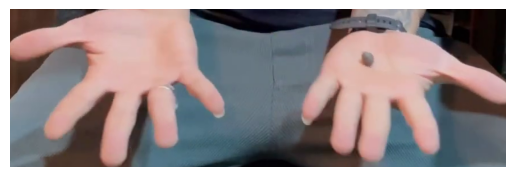

Frame 13:
  text: Non empty hands ~ prob: 0.7351
  text: Empty hands ~ prob: 0.2649


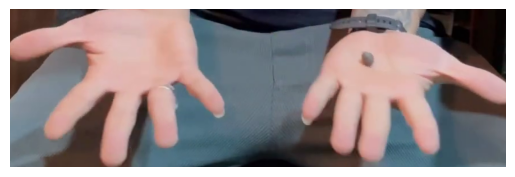

Frame 14:
  text: Non empty hands ~ prob: 0.5676
  text: Empty hands ~ prob: 0.4324


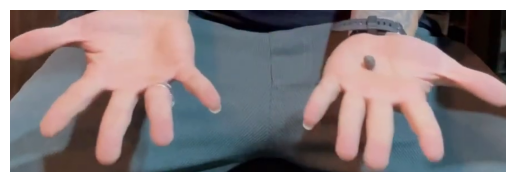

Frame 15:
  text: Non empty hands ~ prob: 0.6644
  text: Empty hands ~ prob: 0.3356


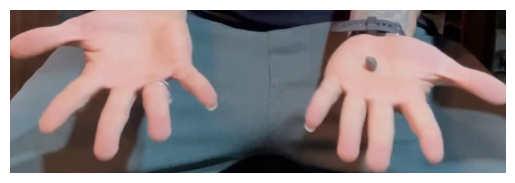

Frame 16:
  text: Non empty hands ~ prob: 0.6644
  text: Empty hands ~ prob: 0.3356


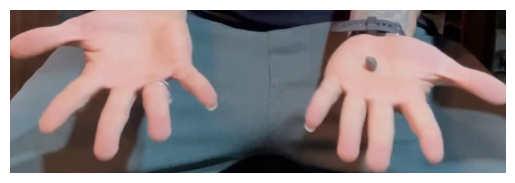

Frame 17:
  text: Non empty hands ~ prob: 0.6522
  text: Empty hands ~ prob: 0.3478


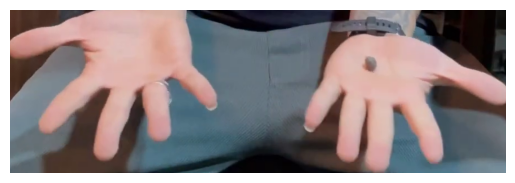

Frame 18:
  text: Non empty hands ~ prob: 0.6065
  text: Empty hands ~ prob: 0.3935


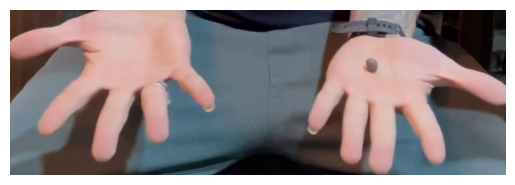

Frame 19:
  text: Non empty hands ~ prob: 0.6339
  text: Empty hands ~ prob: 0.3661


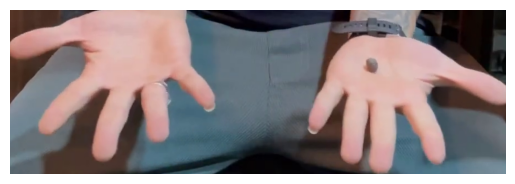

Frame 20:
  text: Non empty hands ~ prob: 0.6606
  text: Empty hands ~ prob: 0.3394


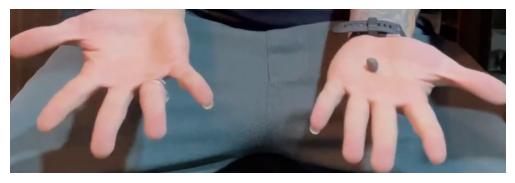

Frame 21:
  text: Non empty hands ~ prob: 0.6606
  text: Empty hands ~ prob: 0.3394


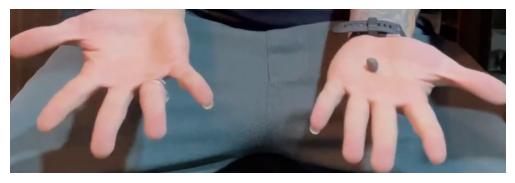

Frame 22:
  text: Non empty hands ~ prob: 0.6601
  text: Empty hands ~ prob: 0.3399


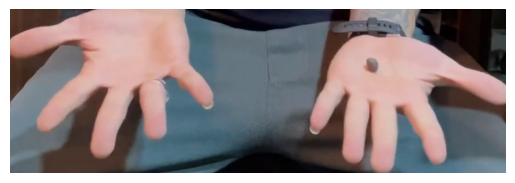

Frame 23:
  text: Non empty hands ~ prob: 0.5824
  text: Empty hands ~ prob: 0.4176


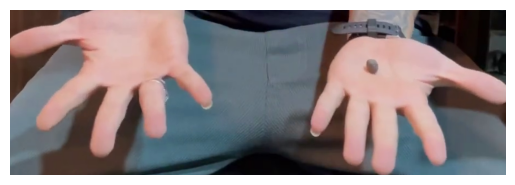

Frame 24:
  text: Non empty hands ~ prob: 0.5646
  text: Empty hands ~ prob: 0.4354


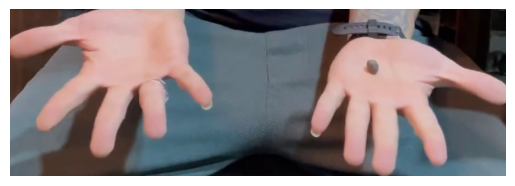

Frame 25:
  text: Non empty hands ~ prob: 0.5845
  text: Empty hands ~ prob: 0.4155


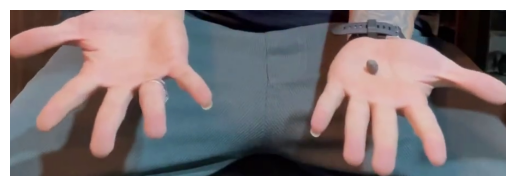

Frame 26:
  text: Non empty hands ~ prob: 0.5618
  text: Empty hands ~ prob: 0.4382


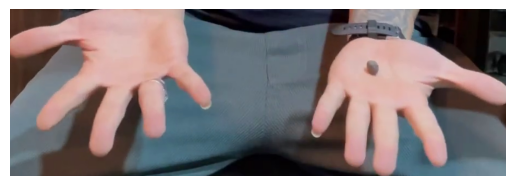

Frame 27:
  text: Non empty hands ~ prob: 0.5024
  text: Empty hands ~ prob: 0.4976


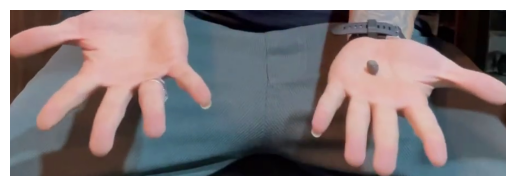

Frame 28:
  text: Non empty hands ~ prob: 0.5721
  text: Empty hands ~ prob: 0.4279


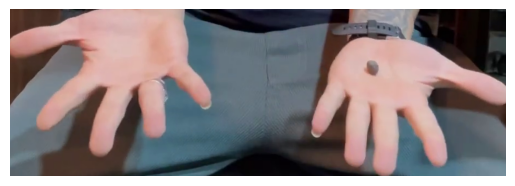

Frame 29:
  text: Non empty hands ~ prob: 0.5434
  text: Empty hands ~ prob: 0.4566


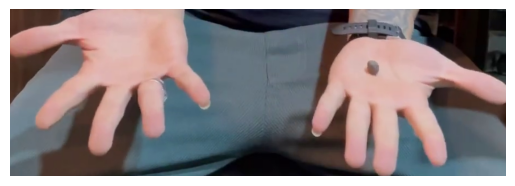

Frame 30:
  text: Non empty hands ~ prob: 0.5786
  text: Empty hands ~ prob: 0.4214


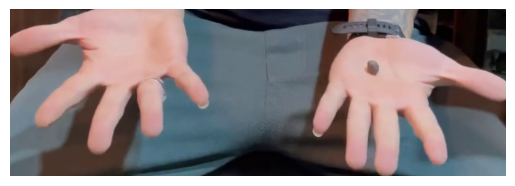

Frame 31:
  text: Non empty hands ~ prob: 0.5784
  text: Empty hands ~ prob: 0.4216


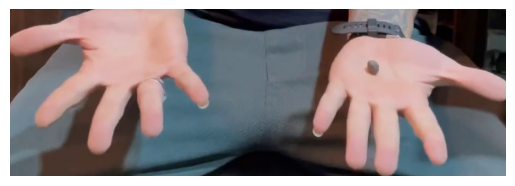

Frame 32:
  text: Non empty hands ~ prob: 0.5782
  text: Empty hands ~ prob: 0.4218


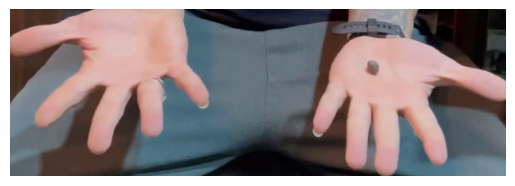

Frame 33:
  text: Non empty hands ~ prob: 0.6182
  text: Empty hands ~ prob: 0.3818


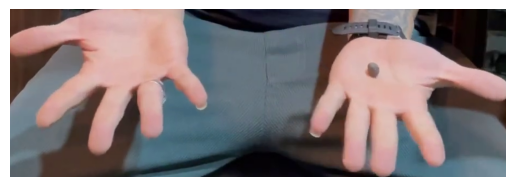

Frame 34:
  text: Non empty hands ~ prob: 0.5515
  text: Empty hands ~ prob: 0.4485


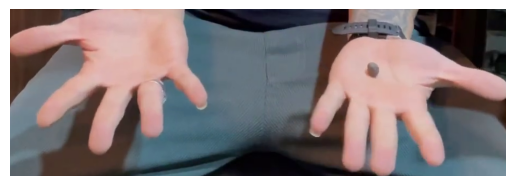

Frame 35:
  text: Non empty hands ~ prob: 0.7141
  text: Empty hands ~ prob: 0.2859


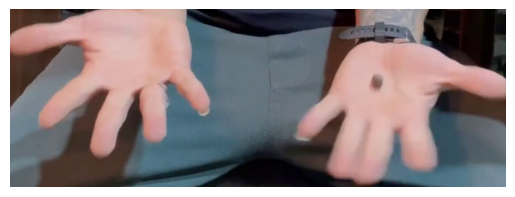

Frame 36:
  text: Non empty hands ~ prob: 0.7149
  text: Empty hands ~ prob: 0.2851


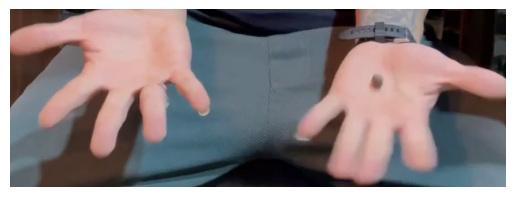

Frame 37:
  text: Non empty hands ~ prob: 0.7415
  text: Empty hands ~ prob: 0.2585


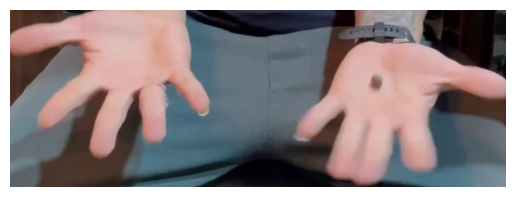

In [59]:
# Get item predictions for each frame in the first "Open Hands" range
text_candidates = ["Non empty hands", "Empty hands"]

start, end = first_open_range

# Get text candidates probabilities for the first "Open Hands" range
probs_array_first_range = get_text_candidates_probabilities(full_images[start:end + 1], text_candidates)

Frame with the highest probability for 'Non empty hands' in the first 'Open Hands' range: Frame 11 with probability 0.7426


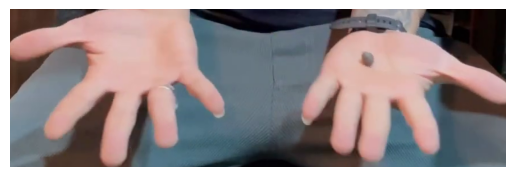

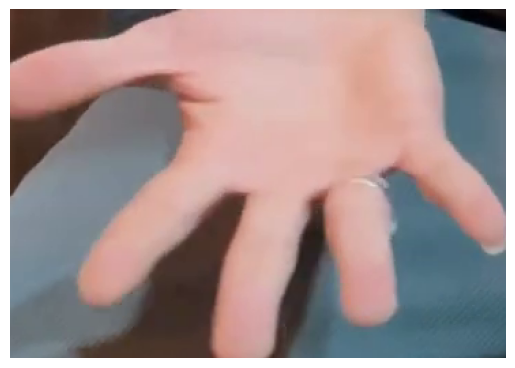

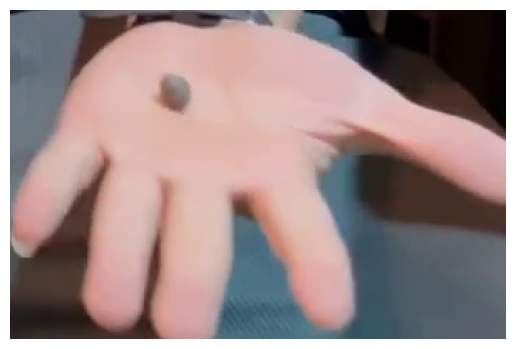

In [60]:
# Get index of the frame with the highest probability for the first text candidate ("Non empty hands")
max_prob_idx_first_range = np.argmax(probs_array_first_range[:, 0])  # 0 index is for "Non empty hands"
max_prob_frame_first_range = full_images[start + max_prob_idx_first_range]
max_single_prob_frames_first_range = single_images_pairs[start + max_prob_idx_first_range]

print(f"Frame with the highest probability for 'Non empty hands' in the first 'Open Hands' range: Frame {start + max_prob_idx_first_range + 1} with probability {probs_array_first_range[max_prob_idx_first_range, 0]:.4f}")

# Display the frame with the highest probability for "Non empty hands" in the first "Open Hands" range
plt.imshow(cv2.cvtColor(max_prob_frame_first_range, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Display individual hand crops 
for idx, hand_crop in enumerate(max_single_prob_frames_first_range):
    plt.imshow(cv2.cvtColor(hand_crop, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [ ]:
# Get Preiction for object position on hands for the first "Open Hands" range
# Text candidates
text_candidates = ["Object on right hand", "Object on left hand"]

# Process each frame and print predictions
texts, probs = retrieve_text_for_frame(max_prob_frame_first_range, text_candidates, models=model_tokenizer, topk=2)
print(f"Image {i+1}:")
for t, p in zip(texts, probs):
    print(f"  text: {t} ~ prob: {p:.4f}")

Image 151:
  text: Object on left hand ~ prob: 0.8592
  text: Object on right hand ~ prob: 0.1408


c:\Users\Sai\Documents\Neu\video-annotation\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\Sai\Documents\Neu\video-annotation\.venv\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [ ]:
# Get text candidates probabilities for the last "Open Hands" range
text_candidates = ["Non empty hands", "Empty hands"]
start, end = last_open_range

probs_array_last_range = get_text_candidates_probabilities(full_images[start:end + 1], text_candidates)

Frame with the highest probability for 'Non empty hands' in the last 'Open Hands' range: Frame 121 with probability 0.4370


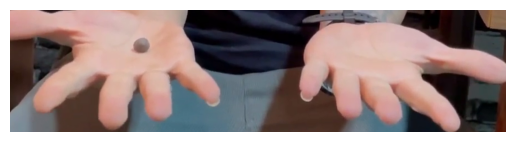

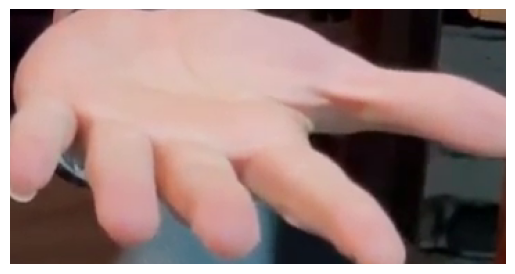

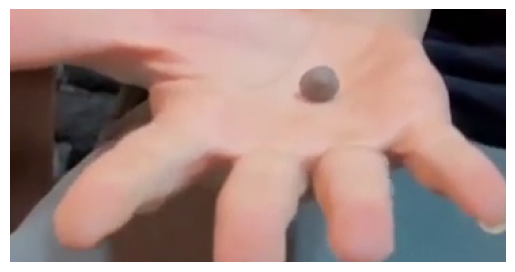

In [65]:
# Get index of the frame with the highest probability for the first text candidate ("Non empty hands")
max_prob_idx_last_range = np.argmax(probs_array_last_range[:, 0])  # 0 index is for "Non empty hands"
max_prob_frame_last_range = full_images[start + max_prob_idx_last_range]
max_single_prob_frames_last_range = single_images_pairs[start + max_prob_idx_last_range]

print(f"Frame with the highest probability for 'Non empty hands' in the last 'Open Hands' range: Frame {start + max_prob_idx_last_range + 1} with probability {probs_array_last_range[max_prob_idx_last_range, 0]:.4f}")

# Display the frame with the highest probability for "Non empty hands" in the last "Open Hands" range
plt.imshow(cv2.cvtColor(max_prob_frame_last_range, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Display individual hand crops
for idx, hand_crop in enumerate(max_single_prob_frames_last_range):
    plt.imshow(cv2.cvtColor(hand_crop, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [66]:
# Get Preiction for object position on hands for the last "Open Hands" range
# Text candidates
text_candidates = ["Object on right hand", "Object on left hand"]

# Process each frame and print predictions
texts, probs = retrieve_text_for_frame(max_prob_frame_last_range, text_candidates, models=model_tokenizer, topk=2)
print(f"Image {i+1}:")
for t, p in zip(texts, probs):
    print(f"  text: {t} ~ prob: {p:.4f}")

Image 151:
  text: Object on left hand ~ prob: 0.6846
  text: Object on right hand ~ prob: 0.3154


In [ ]:
# Text candidates
text_candidates = ["An item is resting on the hand", "The hands are empty"]

# Process each frame and print predictions
for i, frame in enumerate(max_single_prob_frames):
    texts, probs = retrieve_text_for_frame(frame, text_candidates, models=model_tokenizer, topk=2)
    print(f"Image {i+1}:")
    for t, p in zip(texts, probs):
        print(f"  text: {t} ~ prob: {p:.4f}")

Image 1:
  text: The hand is empty ~ prob: 0.9175
  text: An item is resting on the hand ~ prob: 0.0825
Image 2:
  text: The hand is empty ~ prob: 0.7998
  text: An item is resting on the hand ~ prob: 0.2002
